## 기본 감정분류 모델 구축

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Emotion/

/content/drive/My Drive/Colab Notebooks/Emotion


In [ ]:
!ls

 best_model.h5		  final_scores_1.csv	      parameter_result_1.csv
 df4.csv		  final_scores_2.csv	      parameter_result_2_10.csv
 df8.csv		  final_scores_3.csv	      parameter_result_2_11.csv
 df_result		  final_scores_4.csv	      parameter_result_2_12.csv
 df_result.csv		  final_scores_5.csv	      parameter_result_2_1.csv
 distances_10.csv	  final_scores_6.csv	      parameter_result_2_2.csv
 distances_11.csv	  index.csv		      parameter_result_2_3.csv
 distances_12.csv	  index.pickle		      parameter_result_2_4.csv
 distances_1.csv	  KoBert_emotion.pt	      parameter_result_2_5.csv
 distances_2.csv	  parameter_result_1_10.csv   parameter_result_2_6.csv
 distances_3.csv	  parameter_result_1_11.csv   parameter_result_2_7.csv
 distances_4.csv	  parameter_result_1_12.csv   parameter_result_2_8.csv
 distances_5.csv	  parameter_result_1_1.csv    parameter_result_2_9.csv
 distances_6.csv	  parameter_result_1_2.csv    range.xlsx
 distances_7.csv	  parameter_result_1_3.csv    similarity_2.csv


In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3
!pip install torch==1.12.1

!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 KB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp39-cp39-linux_x86_64.whl size=680526 sha256=80dc54bba24873c928fed24d8047f5ee06987f11f537c0c47cb9b8b9d6d4ffc6
  Stored in directory: /root/.cache/pip/wheels/47/17/70/b257bc53879a458c4bfcc900e89271aa8b4f19366a54bd2455
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings(action='ignore')

ModuleNotFoundError: ignored

In [ ]:
device = torch.device("cuda:0")

bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/drive/My Drive/Colab Notebooks/Emotion/.cache/kobert_v1.zip
using cached model. /content/drive/MyDrive/Colab Notebooks/Emotion/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
import pandas as pd
df = pd.read_csv('감정 분류 데이터셋.csv',encoding='cp949')
df = df.iloc[:, [1, 2]]
df2 = pd.read_excel('speech.xlsx')

In [ ]:
df3 = df2.iloc[1:2000,[1,2]]
df3.columns=['대화', '감정']

In [ ]:
df.loc[(df['1번 감정'] == "angry"), '1번 감정'] = 0
df.loc[(df['1번 감정'] == "anger"), '1번 감정'] = 0
df.loc[(df['1번 감정'] == "disgust"), '1번 감정'] = 0
df.loc[(df['1번 감정'] == "fear"), '1번 감정'] = 0
df.loc[(df['1번 감정'] == "sadness"), '1번 감정'] = 0
df.loc[(df['1번 감정'] == "sad"), '1번 감정'] = 0
df.loc[(df['1번 감정'] == "neutral"), '1번 감정'] = 1
df.loc[(df['1번 감정'] == "surprise"), '1번 감정'] = 1
df.loc[(df['1번 감정'] == "happiness"), '1번 감정'] = 2
df.columns=['대화', '감정']

In [ ]:
df3.loc[(df3['감정'] == "슬픔"), '감정'] = 0
df3.loc[(df3['감정'] == "공포"), '감정'] = 0
df3.loc[(df3['감정'] == "혐오"), '감정'] = 0
df3.loc[(df3['감정'] == "분노"), '감정'] = 0
df3.loc[(df3['감정'] == "부정"), '감정'] = 0
df3.loc[(df3['감정'] == "중립"), '감정'] = 1
df3.loc[(df3['감정'] == "놀람"), '감정'] = 1
df3.loc[(df3['감정'] == "행복"), '감정'] = 2
df3.loc[(df3['감정'] == "긍정"), '감정'] = 2

In [ ]:
df_test = pd.read_csv('emotion_labeling.csv', encoding='cp949')
df_test.loc[(df_test['감정'] == '공포'), '감정'] = 0
df_test.loc[(df_test['감정'] == '분노'), '감정'] = 0
df_test.loc[(df_test['감정'] == '슬픔'), '감정'] = 0
df_test.loc[(df_test['감정'] == '혐오'), '감정'] = 0
df_test.loc[(df_test['감정'] == '부정'), '감정'] = 0
df_test.loc[(df_test['감정'] == '놀람'), '감정'] = 1
df_test.loc[(df_test['감정'] == '중립'), '감정'] = 1
df_test.loc[(df_test['감정'] == '긍정'), '감정'] = 2

In [ ]:
print(np.unique(df['감정']))
print(np.unique(df_test.감정))

[0 1 2]
[0 1 2]


In [ ]:
train_df = pd.concat([df, df3])
test_df = df_test

In [ ]:
train = []
for q, label in zip(train_df['대화'], train_df['감정'])  :
    data = []
    data.append(q)
    data.append(str(label))

    train.append(data)

In [ ]:
test = []
for q, label in zip(test_df['대화'], test_df['감정'])  :
    data = []
    data.append(q)
    data.append(str(label))

    test.append(data)

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test, 0, 1, tok, max_len, True, False)

using cached model. /content/drive/MyDrive/Colab Notebooks/Emotion/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 3, # softmax 사용 <- binary일 경우는 2
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)


In [ ]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
# 옵티마이저 선언
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # softmax용 Loss Function 정하기 <- binary classification도 해당 loss function 사용 가능

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # gradient clipping
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval() # 평가 모드로 변경

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/278 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.1344650983810425 train acc 0.3125
epoch 1 batch id 201 loss 0.7137171626091003 train acc 0.619092039800995
epoch 1 train acc 0.6309144991698948


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 1 test acc 0.6212399732620321


  0%|          | 0/278 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.0234465599060059 train acc 0.515625
epoch 2 batch id 201 loss 0.6781501770019531 train acc 0.7515547263681592
epoch 2 train acc 0.7413530713890426


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 2 test acc 0.6473094919786097


  0%|          | 0/278 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.8042266368865967 train acc 0.671875
epoch 3 batch id 201 loss 0.7733079195022583 train acc 0.7884794776119403
epoch 3 train acc 0.7834419964028777


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 3 test acc 0.6554144385026738


  0%|          | 0/278 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.6831105351448059 train acc 0.703125
epoch 4 batch id 201 loss 0.6827996373176575 train acc 0.8063588308457711
epoch 4 train acc 0.8000873339789707


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 4 test acc 0.6783923796791445


  0%|          | 0/278 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.6140812635421753 train acc 0.734375
epoch 5 batch id 201 loss 0.6943405866622925 train acc 0.8311567164179104
epoch 5 train acc 0.8248132263420034


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 5 test acc 0.7113135026737968


In [ ]:
def classify_emotion(sentences):    # 감정 분류 함수

  unseen_values = pd.DataFrame([[sentences, 0]], columns = [['대화 내용', '감정']]).values
  test_set = BERTDataset(unseen_values, 0, 1, tok, max_len, True, False)
  test_input = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=5)

  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_input):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    out = model(token_ids, valid_length, segment_ids)
    max_vals, max_indices = torch.max(out, 1)

    temp = max_indices.data.cpu().numpy()
    if temp == [0]:
      final_value = -1
    elif temp == [1]:
      final_value = 0
    else:
      final_value = 1

  return final_value

In [ ]:
# 예시문장
classify_emotion('생크림은 질색이야')

-1

## 예시 문장

In [ ]:
import time

In [ ]:
def score_1(sentences_list): # 점수 측정 함수
    start = time.time()
    X = []
    for i in range(len(sentences_list)):

      x_1 = classify_emotion(sentences_list[i])

      if i == 0:
        x_2 = (classify_emotion(sentences_list[i]) + classify_emotion(sentences_list[i+1]))/2
      elif i == (len(sentences_list)-1):
        x_2 = (classify_emotion(sentences_list[i]) + classify_emotion(sentences_list[i-1]))/2
      else:
        x_2 = (classify_emotion(sentences_list[i]) + classify_emotion(sentences_list[i-1]) + classify_emotion(sentences_list[i+1]) )/3

      X_3 = 0
      for i in range(len(sentences_list)):
        temp = classify_emotion(sentences_list[i])
        X_3 = X_3 + temp

      x_3 = X_3 / len(sentences_list)

      x = x_1*0.4 + x_2*0.3 + x_3*0.3
      X.append(x)
      end = time.time() - start
    return(X, end)

In [ ]:
def score_2(sentences_list): # 점수 측정 함수
    start = time.time()
    X = list(0 for i in range(len(sentences_list)))
    X_1 = list(0 for i in range(len(sentences_list)))
    X_2 = list(0 for i in range(len(sentences_list)))
    X_3 = 0

    for i in range(len(sentences_list)):
      X_1[i]= classify_emotion(sentences_list[i])
    X_3 = np.mean(X_1)
    for i in range(len(sentences_list)):
      if i == 0:
        x_2 = (X_1[i] +X_1[i+1])/2
      elif i == (len(sentences_list)-1):
        x_2 = (X_1[i] + X_1[i-1])/2
      else:
        x_2 = (X_1[i] + X_1[i-1] + X_1[i+1])/3
      X_2[i] = x_2

      X[i]= X_1[i]*0.4 + X_2[i]*0.3 + X_3*0.3
      end = time.time()
    return(X, end-start)

In [ ]:
sent_1 = ['끝나고 디저트 카페 어때요?',
        '그럼요~ 여기 쇼트케이크 진짜 맛있어요!',
        ' 아뇨,, 뭐 그냥 크게 걱정 안해요. ㅋㅋ 먹고 싶은 거 먹는 거죠 뭐',
        ' 그래요? 싫어하는 사람도 있구나, 그럼 초콜릿은요? 초콜릿 진짜 맛있어요!']

In [ ]:
sent_2 = ['아.. 디저트요? 좀 곤란한데요.. 좋아하시나요?',
          '하아.. 저는 디저트로 뚱뚱해지는게 싫어요.. 그런 걱정 안하시나봐요..',
          '대단하시네요. 전 생크림은 질색이에요.',
          '초콜릿도 잘 안 먹어요..ㅠㅠ']

In [ ]:
score_1 = score_1(sent_1)
score_1

([0.3, 0.65, 0.35, 0.7000000000000001], 9.848503589630127)

In [ ]:
score_1 = score_2(sent_1)
score_1

([0.3, 0.65, 0.35, 0.7000000000000001], 1.3007876873016357)

In [ ]:
score_2 = score(sent_2)
score_2

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.plot(score_1, label='Person 1')
plt.plot(score_2, color='red', label='Person 2')
plt.ylim(-1, 1)
plt.legend()
plt.show()

In [ ]:
sent_3 = ['오늘 저녁 뭐 드셨어요?',
      '와~ 맛있으셨나요?',
      '저는 로제 떡볶이 먹어본 적 없어요.. 어떤 맛인가요?',
      '네 궁금하네요 ㅋㅋㅋ 한번 먹어봐야겠어요!',
      '전 김치찌개 먹었어요! 저는 저희 집 김치찌개가 젤 맛있는 것 같아요 ㅋㅋ',
      '저는 참치 넣는 것 좋아해요',
      '엄마표가 최고에요 진짜 ㅋㅋ']

In [ ]:
sent_4 = ['오늘은 떡군이네 떡볶이라는 곳에서 로제 떡볶이 시켜 먹었어요.',
          '네 맛있더라고요. 한창 유행일 때는 잘 안 먹엇는데, 뒤늦게 자주 먹고 있어요.',
          '약간 떡 같은데 좀 더 쫄깃한 맛이에요. 나중에 한번 드셔보세요.',
          '꼭 배민에서 시켜 드세요. 거기꺼가 맛있어요. ㅋㅋ 혹시 저녁 뭐 드셨나요?',
          '역시 김치찌개 맛있죠! 뭐 넣어 드시는 거 좋아하세요?',
          '저희 엄마도 참치 좋아하셔서 언제나 참치 김치찌개에요.',
          '그렇죠 ㅋㅋ']

In [ ]:
score_3 = score(sent_3)
score_3

In [ ]:
score_4 = score(sent_4)
score_4

In [ ]:
import matplotlib.pyplot as plt
plt.plot(score_3, label='Person 1')
plt.plot(score_4, color='red', label='Person 2')
plt.ylim(-1, 1)
plt.legend()
plt.show()

## 다른 유사도 측정 지표 고민

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [ ]:
cos_sim(score_1, score_2)

In [ ]:
cos_sim(score_3, score_4)

In [ ]:
def euclidean(x, y):
  x = np.array(x)
  y = np.array(y)
  return np.sqrt(np.sum((x-y)**2))

In [ ]:
euclidean(score_1, score_2)

In [ ]:
euclidean(score_3, score_4)

In [ ]:
def manhattan(x, y):
  x = np.array(x)
  y = np.array(y)
  return np.sum(np.abs(x-y))

In [ ]:
manhattan(score_1, score_2)

In [ ]:
manhattan(score_3, score_4)

## 실제 적용

In [ ]:
df4 = pd.read_csv('df4.csv')
#df4 = df4.dropna(axis=1)
#intimacy = df4.iloc[4000:6000,-1]
df4 = df4.iloc[:115, 3:22]
df4

In [ ]:
df4.isnull().sum()

In [ ]:
person_1 = []
person_2 = []
for i in range(len(df4)):
  sent_person_1 = []
  sent_person_2 = []
  for i2 in range(19):
    if (i2 %2 == 0) & (str(df4.iloc[i, i2]) != 'nan'):
      sent_person_1.append(df4.iloc[i,i2])
    elif (i2 %2 ==1) & (str(df4.iloc[i, i2]) != 'nan'):
      sent_person_2.append(df4.iloc[i,i2])

  person_1.append(sent_person_1)
  person_2.append(sent_person_2)

In [ ]:
def score_final(sentences_list): # 점수 측정 함수
    X = list(0 for i in range(len(sentences_list)))
    X_1 = list(0 for i in range(len(sentences_list)))
    X_2 = list(0 for i in range(len(sentences_list)))
    X_3 = 0

    for i in range(len(sentences_list)):
      X_1[i]= classify_emotion(sentences_list[i])
    X_3 = np.mean(X_1)
    for i in range(len(sentences_list)):
      if i == 0:
        x_2 = (X_1[i] +X_1[i+1])/2
      elif i == (len(sentences_list)-1):
        x_2 = (X_1[i] + X_1[i-1])/2
      else:
        x_2 = (X_1[i] + X_1[i-1] + X_1[i+1])/3
      X_2[i] = x_2

      X[i]= X_1[i]*0.4 + X_2[i]*0.3 + X_3*0.3

    return(X)

In [ ]:
scores_1 = []
scores_2 = []
for i in range(len(df4)):
  scores_1.append(score_final(person_1[i]))
  scores_2.append(score_final(person_2[i]))

In [ ]:
scores_1[0]

[-0.64,
 -0.19,
 -0.19,
 -0.59,
 -0.29,
 -0.59,
 -0.19,
 0.009999999999999995,
 0.31000000000000005,
 -0.49]

In [ ]:
'''
상, 중, 중, 하, 상, 상, 중, 상,
중, 하, 상, 하, 중, 중, 하, 상,
상, 중, 상, 하, 상, 상, 상, 상,
중, 하, 중, 상, 상, 하, 중, 하,
상, 중, 상, 상, 중, 상, 중, 하
중, 중, 상, 하, 상, 중, 상, 중,
중, 중, 하, 중, 중, 상, 중, 상,
중, 상, 하, 중, 상, 상, 중, 중,
중, 상, 중, 상, 상, 중, 상, 하,
하, 상, 상, 상, 상, 상, 중, 중
상, 중, 상, 상, 중, 중, 상, 상,
상, 중, 하, 하, 중, 중, 상, 상,
하, 상, 하, 상, 중, 상, 중, 하,
상, 상, 중, 중, 상, 상, 하, 중,
중, 중, 중
'''

In [ ]:
pip install dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 67.9 MB/s eta 0:00:00


In [ ]:
print(len(scores_2))
print(len(scores_1))

2000
2000


In [ ]:
from dtaidistance import dtw

distance = []
for i in range(len(scores_1)):
  distance.append(dtw.distance(scores_1[i], scores_2[i]))

In [ ]:
df['similarity'] = df['distance'].map(lambda x: 1-x)

In [ ]:
manhattan_ = []
cosine = []
euclidean_ = []

for i in range(len(scores_1)):
  manhattan_.append(manhattan(scores_1[i], scores_2[i]))
  cosine.append(cos_sim(scores_1[i], scores_2[i]))
  euclidean_.append(euclidean(scores_1[i], scores_2[i]))

NameError: ignored

In [ ]:
len(distance)

In [ ]:
df = pd.DataFrame({'distance': distance, 'intimacy': intimacy})
df

,distance,intimacy
4000,1.242305,5
4001,0.759934,0
4002,0.000000,0
4003,1.320377,5
4004,0.357071,5
...,...,...
5995,0.403113,0
5996,0.463681,0
5997,1.025914,0
5998,0.835775,0


In [ ]:
df.to_csv('similarity_3.csv')

In [ ]:
import pandas as pd
df = pd.read_csv('similarity.csv')
df

,Unnamed: 0,distance,intimacy
0,0,0.000000,0
1,1,0.397890,5
2,2,1.237053,0
3,3,1.016898,5
4,4,1.157365,0
...,...,...,...
1995,1995,1.155422,5
1996,1996,0.240747,5
1997,1997,1.352775,0
1998,1998,1.095445,5


In [ ]:
df['similarity'] = df['distance'].map(lambda x: 1-x)

In [ ]:
df.sort_values('similarity').head(10)

,Unnamed: 0,distance,intimacy,similarity
442,442,1.000000,0,0.000000
1597,1597,0.914120,0,0.085880
987,987,0.867697,0,0.132303
150,150,0.858597,0,0.141403
594,594,0.857159,0,0.142841
285,285,0.810902,0,0.189098
193,193,0.796031,0,0.203969
313,313,0.762491,0,0.237509
558,558,0.752269,0,0.247731
1915,1915,0.751841,0,0.248159


In [ ]:
df.sort_values('similarity').tail(10)

,Unnamed: 0,distance,intimacy,similarity
540,540,0.0,0,1.0
1907,1907,0.0,0,1.0
1078,1078,0.0,5,1.0
1074,1074,0.0,0,1.0
664,664,0.0,0,1.0
1901,1901,0.0,0,1.0
1900,1900,0.0,0,1.0
279,279,0.0,0,1.0
1128,1128,0.0,0,1.0
0,0,0.0,0,1.0


In [ ]:
df.loc[df.similarity == 1.0]

,Unnamed: 0,distance,intimacy,similarity
0,0,0.0,0,1.0
5,5,0.0,0,1.0
14,14,0.0,0,1.0
80,80,0.0,0,1.0
84,84,0.0,0,1.0
...,...,...,...,...
1901,1901,0.0,0,1.0
1907,1907,0.0,0,1.0
1923,1923,0.0,0,1.0
1947,1947,0.0,1,1.0


In [ ]:
df[condition]

,Unnamed: 0,distance,intimacy,similarity
2,2,0.409573,0,0.590427
10,10,0.429434,0,0.570566
13,13,0.473656,0,0.526344
16,16,0.541565,0,0.458435
17,17,0.401792,0,0.598208
...,...,...,...,...
1973,1973,0.432953,0,0.567047
1976,1976,0.445803,0,0.554197
1981,1981,0.427219,0,0.572781
1992,1992,0.433766,0,0.566234


In [ ]:
condition = (df.similarity >= 0.4) & (df.similarity <= 0.6)

(array([  2.,   4.,  14.,  31.,  98., 262., 457., 607., 360., 165.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

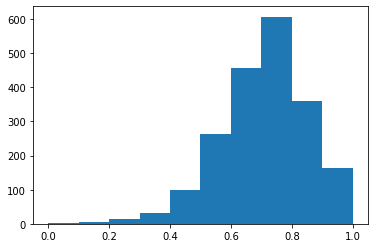

In [ ]:
plt.hist(df.similarity)

In [ ]:
plt.hist(df.similarity, bins=3)

NameError: ignored

In [ ]:
df = df.iloc[:,[1,2]]

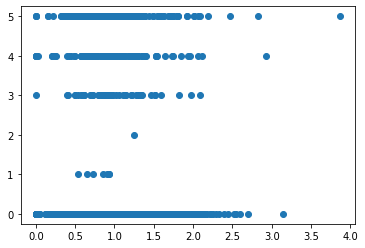

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(distance, intimacy)

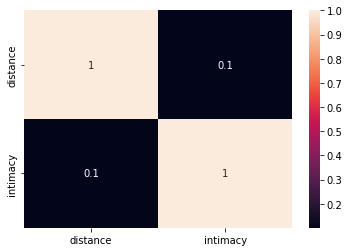

In [ ]:
df_corr = df.corr(method='pearson')
import seaborn as sns
sns.heatmap(df_corr, annot=True)

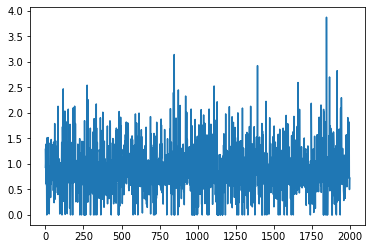

In [ ]:
plt.plot(df.distance)

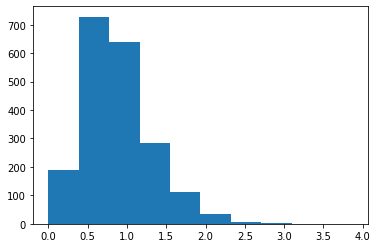

In [ ]:
plt.hist(df.distance);

In [ ]:
distance = df.distance.values
type(distance)

numpy.ndarray

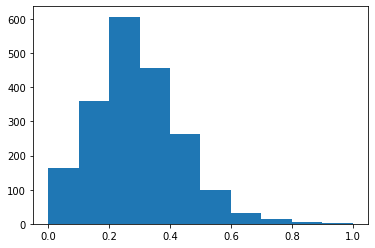

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
scaler = MinMaxScaler()
df.distance = scaler.fit_transform(df.distance.values.reshape(-1, 1))
plt.hist(df.distance);

(array([  27.,  630., 1343.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

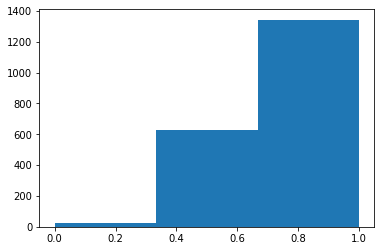

In [ ]:
plt.hist(1- df.distance, bins=3)

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
df[:115]

,Unnamed: 0,distance,intimacy
0,0,0.000000,0
1,1,0.131736,5
2,2,0.409573,0
3,3,0.336682,5
4,4,0.383189,0
5,5,0.000000,0
6,6,0.374734,0
7,7,0.271007,4
8,8,0.219619,5
9,9,0.173253,0


In [ ]:
df['distance']= df.distance

(array([189., 728., 640., 285., 111.,  35.,   8.,   2.,   1.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

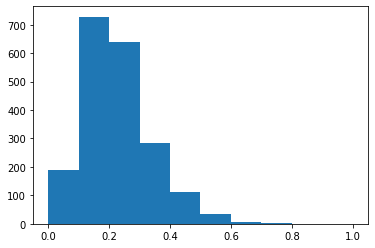

In [ ]:
plt.hist(distance, bins=10)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc37c04fc10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc37c05e310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc37c04f8b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc37c05e9d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc37c05ecd0>],
 'means': []}

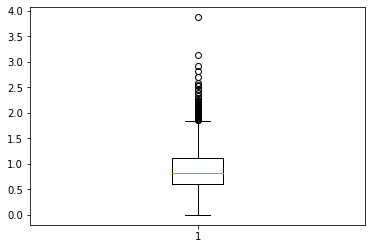

In [ ]:
plt.boxplot(df.distance)

In [ ]:
df.describe()

,distance,intimacy
count,2000.000000,2000.000000
mean,0.878703,0.972500
std,0.453427,1.870426
min,0.000000,0.000000
25%,0.610328,0.000000
50%,0.817628,0.000000
75%,1.106372,0.000000
max,3.871298,5.000000


In [ ]:
import pandas as pd
df = pd.read_csv('similarity.csv')
df

,Unnamed: 0,distance,intimacy
0,0,0.000000,0
1,1,0.397890,5
2,2,1.237053,0
3,3,1.016898,5
4,4,1.157365,0
...,...,...,...
1995,1995,1.155422,5
1996,1996,0.240747,5
1997,1997,1.352775,0
1998,1998,1.095445,5


In [ ]:
df.describe()

,Unnamed: 0,distance,intimacy
count,2000.000000,2000.000000,2000.000000
mean,999.500000,0.867662,0.800000
std,577.494589,0.439744,1.748579
min,0.000000,0.000000,0.000000
25%,499.750000,0.597913,0.000000
50%,999.500000,0.815819,0.000000
75%,1499.250000,1.121940,0.000000
max,1999.000000,3.020348,5.000000


(array([165., 360., 607., 457., 262.,  98.,  31.,  14.,   4.,   2.]),
 array([0.        , 0.30203477, 0.60406953, 0.9061043 , 1.20813906,
        1.51017383, 1.8122086 , 2.11424336, 2.41627813, 2.7183129 ,
        3.02034766]),
 <a list of 10 Patch objects>)

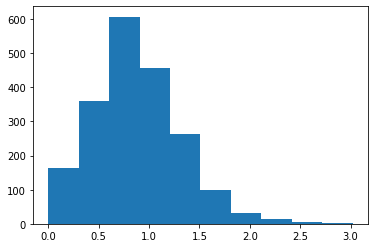

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df.distance)

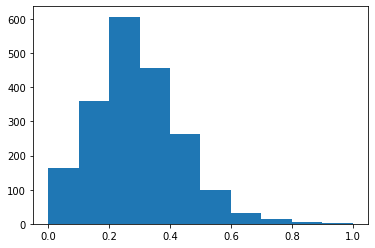

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
scaler = MinMaxScaler()
df.distance = scaler.fit_transform(df.distance.values.reshape(-1, 1))
plt.hist(df.distance);

(array([  2.,   4.,  14.,  31.,  98., 262., 457., 607., 360., 165.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

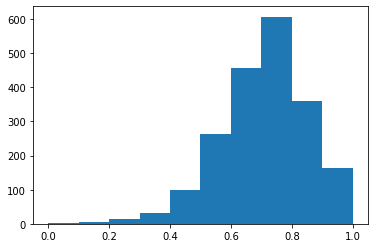

In [ ]:
plt.hist(df.similarity)

In [ ]:
df['similarity'] = df['distance'].map(lambda x: 1-x)
df[:115]

,Unnamed: 0,distance,intimacy,similarity
0,0,0.000000,0,1.000000
1,1,0.131736,5,0.868264
2,2,0.409573,0,0.590427
3,3,0.336682,5,0.663318
4,4,0.383189,0,0.616811
5,5,0.000000,0,1.000000
6,6,0.374734,0,0.625266
7,7,0.271007,4,0.728993
8,8,0.219619,5,0.780381
9,9,0.173253,0,0.826747


In [ ]:
condition = (df.similarity >=0.59) & (df.similarity <=0.80)

In [ ]:
df[condition][:50]

,Unnamed: 0,distance,intimacy,similarity
2,2,0.409573,0,0.590427
3,3,0.336682,5,0.663318
4,4,0.383189,0,0.616811
6,6,0.374734,0,0.625266
7,7,0.271007,4,0.728993
8,8,0.219619,5,0.780381
11,11,0.313661,0,0.686339
15,15,0.310146,0,0.689854
17,17,0.401792,0,0.598208
18,18,0.238106,0,0.761894


In [ ]:
상 = 1
중 = 0.5
하 = 0

In [ ]:
scores = [상, 중, 중, 하, 상, 상, 중, 상,
중, 하, 상, 하, 중, 중, 하, 상,
상, 중, 상, 하, 상, 상, 상, 상,
중, 하, 중, 상, 상, 하, 중, 하,
상, 중, 상, 상, 중, 상, 중, 하,
중, 중, 상, 하, 상, 중, 상, 중,
중, 중, 하, 중, 중, 상, 중, 상,
중, 상, 하, 중, 상, 상, 중, 중,
중, 상, 중, 상, 상, 중, 상, 하,
하, 상, 상, 상, 상, 상, 중, 중,
상, 중, 상, 상, 중, 중, 상, 상,
상, 중, 하, 하, 중, 중, 상, 상,
하, 상, 하, 상, 중, 상, 중, 하,
상, 상, 중, 중, 상, 상, 하, 중,
중, 중, 중]

In [ ]:
human = df.similarity[:115]

In [ ]:
pd.concat([human, scores], axis=1)

TypeError: ignored

In [ ]:
import pickle
with open("topic_sim.pkl","rb") as fr:
    data = pickle.load(fr)
print(data)


[(0.6641690547719147, 0), (0.7754680181670394, 1), (0.3887111625323693, 2), (0.4043671223852369, 3), (0.7379680941975306, 4), (0.6634248367764732, 5), (0.7554684667675584, 6), (0.614754707661886, 7), (0.56757924321926, 8), (0.35103593965371455, 9), (0.6885097057295112, 10), (0.2876265207926432, 11), (0.45342715299791764, 12), (0.23629875663253996, 13), (0.5854254844513807, 14), (0.6974623855316278, 15), (0.8061859504279928, 16), (0.7058923805880751, 17), (0.6484857960389211, 18), (0.4389872010432037, 19), (0.6249288257324334, 20), (0.6238095329867469, 21), (0.5628313009486053, 22), (0.6418817748861665, 23), (0.46020507422231494, 24), (0.30426762203375496, 25), (0.42879364717210455, 26), (0.6351996247585003, 27), (0.6875054122909666, 28), (0.3858558257420858, 29), (0.623501850804712, 30), (0.5620146151791271, 31), (0.5401008943716685, 32), (0.39732028610176506, 33), (nan, 34), (0.604320945940752, 35), (0.5318839379100718, 36), (0.7552987684551468, 37), (0.28973767426278857, 38), (0.3847

In [ ]:
print(data[:115])

[(0.6641690547719147, 0), (0.7754680181670394, 1), (0.3887111625323693, 2), (0.4043671223852369, 3), (0.7379680941975306, 4), (0.6634248367764732, 5), (0.7554684667675584, 6), (0.614754707661886, 7), (0.56757924321926, 8), (0.35103593965371455, 9), (0.6885097057295112, 10), (0.2876265207926432, 11), (0.45342715299791764, 12), (0.23629875663253996, 13), (0.5854254844513807, 14), (0.6974623855316278, 15), (0.8061859504279928, 16), (0.7058923805880751, 17), (0.6484857960389211, 18), (0.4389872010432037, 19), (0.6249288257324334, 20), (0.6238095329867469, 21), (0.5628313009486053, 22), (0.6418817748861665, 23), (0.46020507422231494, 24), (0.30426762203375496, 25), (0.42879364717210455, 26), (0.6351996247585003, 27), (0.6875054122909666, 28), (0.3858558257420858, 29), (0.623501850804712, 30), (0.5620146151791271, 31), (0.5401008943716685, 32), (0.39732028610176506, 33), (nan, 34), (0.604320945940752, 35), (0.5318839379100718, 36), (0.7552987684551468, 37), (0.28973767426278857, 38), (0.3847

In [ ]:
list(data[:115])

[(0.6641690547719147, 0),
 (0.7754680181670394, 1),
 (0.3887111625323693, 2),
 (0.4043671223852369, 3),
 (0.7379680941975306, 4),
 (0.6634248367764732, 5),
 (0.7554684667675584, 6),
 (0.614754707661886, 7),
 (0.56757924321926, 8),
 (0.35103593965371455, 9),
 (0.6885097057295112, 10),
 (0.2876265207926432, 11),
 (0.45342715299791764, 12),
 (0.23629875663253996, 13),
 (0.5854254844513807, 14),
 (0.6974623855316278, 15),
 (0.8061859504279928, 16),
 (0.7058923805880751, 17),
 (0.6484857960389211, 18),
 (0.4389872010432037, 19),
 (0.6249288257324334, 20),
 (0.6238095329867469, 21),
 (0.5628313009486053, 22),
 (0.6418817748861665, 23),
 (0.46020507422231494, 24),
 (0.30426762203375496, 25),
 (0.42879364717210455, 26),
 (0.6351996247585003, 27),
 (0.6875054122909666, 28),
 (0.3858558257420858, 29),
 (0.623501850804712, 30),
 (0.5620146151791271, 31),
 (0.5401008943716685, 32),
 (0.39732028610176506, 33),
 (nan, 34),
 (0.604320945940752, 35),
 (0.5318839379100718, 36),
 (0.7552987684551468, 37

In [ ]:
df_topic = pd.DataFrame(data[:115])
df_topic.columns = ['topic_similarity', 'index']

In [ ]:
%ls

 best_model.h5             df_result.csv          similarity_2.csv
'감정 분류 데이터셋.csv'   emotion/               similarity_3.csv
 df4.csv                   emotion.csv            similarity.csv
 df8.csv                   emotion_labeling.csv   speech.xlsx
 df_result                 emotion.zip            topic_sim.pkl


In [ ]:
df

,Unnamed: 0,distance,intimacy,similarity
0,0,0.000000,0,1.000000
1,1,0.131736,5,0.868264
2,2,0.409573,0,0.590427
3,3,0.336682,5,0.663318
4,4,0.383189,0,0.616811
...,...,...,...,...
1995,1995,0.382546,5,0.617454
1996,1996,0.079708,5,0.920292
1997,1997,0.447887,0,0.552113
1998,1998,0.362688,5,0.637312


In [ ]:
emotion_scores = pd.DataFrame(scores)

In [ ]:
df_final = pd.concat([df_topic.topic_similarity, human, emotion_scores], axis=1)
df_final.fillna(0)
df_final.columns = ['topic', 'emotion', 'human']


In [ ]:
import numpy as np
df_final['final_scores'] = (df_final['topic'] + df_final['emotion'])/2

In [ ]:
df_final

,topic,emotion,human,final_scores
0,0.664169,1.000000,1.0,0.832085
1,0.775468,0.868264,0.5,0.821866
2,0.388711,0.590427,0.5,0.489569
3,0.404367,0.663318,0.0,0.533842
4,0.737968,0.616811,1.0,0.677389
...,...,...,...,...
110,0.361114,0.687335,0.0,0.524225
111,0.379106,0.682001,0.5,0.530553
112,0.649981,0.762977,0.5,0.706479
113,0.447850,0.730006,0.5,0.588928


In [ ]:
human_score = [상,	상,	중,	중,	상,	상,	상,	상,
중,	하,	상,	하,	상,	중,	상,	상,
상,	중,	상,	중,	중,	상,	하,	상,
중,	하,	하,	상,	상,	하,	중,	중,
상,	상,	하,	중,	중,	상,	하,	하,
상,	하,	상,	중,	상,	하,	상,	상,
상,	중,	하,	중,	상,	상,	하,	상,
상,	중,	상,	상,	상,	상,	상,	상,
상,	중,	상,	상,	중,	상,	하,	중,
상,	상,	상,	상,	상,	상,	상,	상,
상,	상,	중,	상,	상,	상,	중,	중,
상,	하,	중,	상,	상,	상,	상,	상,
상,	상,	상,	중,	하,	상,	중,	상,
중,	하,	하,	상,	하,	중,	상,	중,
하,	상,	하]


In [ ]:
df_final['humans'] = human_score

In [ ]:
human_scores_2 = [중,	중,	상,	하,	중,	중,	상,	중,	하,	하,
상,	하,	중,	하,	하,	중,	상,	중,	중,	중,
중,	중,	하,	중,	중,	하,	하,	중,	중,	하,
하,	중,	중,	중,	하,	중,	중,	상,	하,	하,
중,	중,	상,	중,	중,	하,	중,	중,	하,	하,
중,	하,	중,	상,	하,	중,	중,	상,	중,	하,
중,	하,	하,	중,	상,	중,	하,	중,	중,	하,
중,	하,	하,	상,	중,	하,	중,	하,	중,	중,
중,	하,	하,	하,	중,	중,	하,	중,	하,	중,
하,	중,	중,	중,	상,	중,	중,	상,	하,	중,
중,	상,	중,	중,	중,	상,	중,	하,	중,	상,
중,	하,	중,	중,	상
]

In [ ]:
df_final['human_2'] = human_scores_2

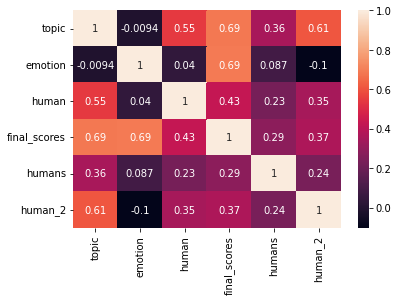

In [ ]:
df_corr = df_final.corr(method='spearman')
import seaborn as sns
sns.heatmap(df_corr, annot=True)

In [ ]:
상 = 1
중 = 0.7
하 = 0

In [ ]:
emotion_scores = [상, 중, 중, 하, 상, 상, 중, 상, 중, 중,
상, 상, 중, 하, 상, 상, 상, 상, 상, 중,
상, 상, 중, 상, 상, 상, 상, 상, 상, 하,
중, 하, 상, 상, 상, 상, 상, 상, 중, 하,
상, 상, 상, 하, 상, 상, 상, 상, 상, 상,
상, 중, 중, 상, 중, 상, 중, 상, 상, 상,
상, 상, 하, 중, 중, 상, 중, 상, 상, 중,
상, 하, 상, 상, 상, 상, 상, 상, 중, 상,
상, 상, 상, 상, 상, 상, 상, 상, 상, 상,
상, 중, 상, 상, 상, 중, 상, 상, 중, 상,
중, 중, 중, 하, 상, 중, 상, 상, 상, 상,
하, 상, 상, 중, 중, 상]

In [ ]:
df

,Unnamed: 0,distance,intimacy
0,0,0.000000,0
1,1,0.397890,5
2,2,1.237053,0
3,3,1.016898,5
4,4,1.157365,0
...,...,...,...
1995,1995,1.155422,5
1996,1996,0.240747,5
1997,1997,1.352775,0
1998,1998,1.095445,5


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df.distance = scaler.fit_transform(df.distance.values.reshape(-1, 1))

In [ ]:
df_score = df.iloc[:116,1]
df_score

0      0.000000
1      0.131736
2      0.409573
3      0.336682
4      0.383189
         ...   
111    0.317999
112    0.237023
113    0.269994
114    0.276513
115    0.506932
Name: distance, Length: 116, dtype: float64

In [ ]:
len(emotion_scores)

116

In [ ]:
df_emotion = pd.concat([pd.DataFrame(emotion_scores), df_score], axis=1)
df_emotion

,0,distance
0,1.0,0.000000
1,0.7,0.131736
2,0.7,0.409573
3,0.0,0.336682
4,1.0,0.383189
...,...,...
111,1.0,0.317999
112,1.0,0.237023
113,0.7,0.269994
114,0.7,0.276513


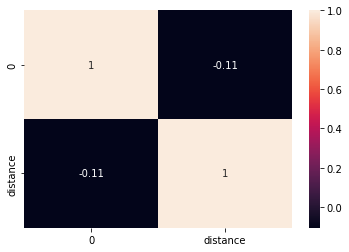

In [ ]:
df_corr = df_emotion.corr(method='pearson')
import seaborn as sns
sns.heatmap(df_corr, annot=True)

In [ ]:
import pandas as pd
df1 = pd.read_csv('similarity.csv')

In [ ]:
df2 = pd.read_csv('similarity_2.csv')

In [ ]:
df3 = pd.read_csv('similarity_3.csv')

In [ ]:
df = pd.concat([df1, df2, df3])
df

,Unnamed: 0,distance,intimacy
0,0,0.000000,0
1,1,0.397890,5
2,2,1.237053,0
3,3,1.016898,5
4,4,1.157365,0
...,...,...,...
1995,5995,0.403113,0
1996,5996,0.463681,0
1997,5997,1.025914,0
1998,5998,0.835775,0


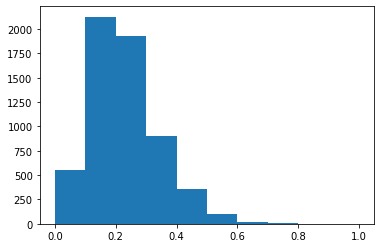

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
scaler = MinMaxScaler()
df.distance = scaler.fit_transform(df.distance.values.reshape(-1, 1))
plt.hist(df.distance);

In [ ]:
df['similarity'] = df['distance'].map(lambda x: 1-x)
df = df.iloc[:, [0, 3]]
df.head()

,Unnamed: 0,similarity
0,0,1.000000
1,1,0.897221
2,2,0.680455
3,3,0.737324
4,4,0.701040


In [ ]:
df.columns = ['index', 'similarity']

In [ ]:
df

,index,similarity
0,0,1.000000
1,1,0.897221
2,2,0.680455
3,3,0.737324
4,4,0.701040
...,...,...
1995,5995,0.895871
1996,5996,0.880226
1997,5997,0.734995
1998,5998,0.784110


In [ ]:
import pickle
df.to_pickle('emotion_similarity.pkl')

In [ ]:
data = pd.read_pickle('emotion_similarity.pkl')
data

,index,similarity
0,0,1.000000
1,1,0.897221
2,2,0.680455
3,3,0.737324
4,4,0.701040
...,...,...
1995,5995,0.895871
1996,5996,0.880226
1997,5997,0.734995
1998,5998,0.784110


## 감정호응도 최적의 가중치 찾기

In [ ]:
상 = 1
중 = 0.5
하 = 0

In [ ]:
emotion_scores = [상, 중, 중, 하, 상, 상, 중, 상, 중, 중,
상, 상, 중, 하, 상, 상, 상, 상, 상, 중,
상, 상, 중, 상, 상, 상, 상, 상, 상, 하,
중, 하, 상, 상, 상, 상, 상, 상, 중, 하,
상, 상, 상, 하, 상, 상, 상, 상, 상, 상,
상, 중, 중, 상, 중, 상, 중, 상, 상, 상,
상, 상, 하, 중, 중, 상, 중, 상, 상, 중,
상, 하, 상, 상, 상, 상, 상, 상, 중, 상,
상, 상, 상, 상, 상, 상, 상, 상, 상, 상,
상, 중, 상, 상, 상, 중, 상, 상, 중, 상,
중, 중, 중, 하, 상, 중, 상, 상, 상, 상,
하, 상, 상, 중, 중, 상 ]

In [ ]:
import pandas as pd
df4 = pd.read_csv('df4.csv')
df4 = df4.iloc[:116, 3:27]
df4

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,다이어트하시나요?,음 요즘은 따로 안 해요 ㅋㅋ 한때 많이 했어요,저도 사실 입다 입어 터라 ㅎㅎ 운동은 뭐 하세요?,운동은 헬스도 하고.. 검도.... 달리기 수영... 정말 다 가끔씩 조금씩 해...,와 대단하세요ㅜㅜ 저는 요즘 걷기만 해요 다재다능하시네요,ㅋㅋ 걷기가 참 좋은 운동 이래요 저도 하려고요 일자목 때문에.. 걷기가 좋다네요,그렇죠 저도 일자목 심해요 수영은 수영장 정기적으로 다니세요?,아니요 한 달에 몇 번 자유수영으로요 일자목 후 안 저리시나요,아직 저리는 단계는 아니에요ᅮ 그러기 전에 교정하고 싶어요ㅜㅜㅜ,ㅜㅜ 진짜 ㅜㅜ안심해지게 관리 잘하세요.. 살날 많이 남았는데 벌써부터 이고생이라...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,그러네 가장 최근에 뭐삼?,가장 최근에 산 거..... 에스트라 샘플 삼 도착은 했는데 언제쯤 개봉할지 미지수,ㅋㅋㅋㅋㅋ 나도 에스트라 저번 주에 샀는데 귀찮아서 안 뜯다가 이거 시작하기 전에...,에스트라가 피부과에서 파는 거랑 그냥 쇼핑몰에서 파는 거랑 성분 다르다는 말이 있...,일단 사봄 지금 쓰는 거 반 정도 남아 가지고. 가격은 비슷하던데 안되면 처방해주...,요즘은 스킨푸드에서 산거 네고 왕 때 샀던 수분크림 이제 뜯어서 쓰고 있어요,시기가 비슷한가 보다 ㅋㅋㅋ 저도요 노란 거 이제 쓰는 중 나쁘지 않음 그리고 그...,아 그 착한 수분크림 어쩌고 너도 쓰고 있니,야스 그거 쓰는 중,화장품 사놓은 거 다 쓰고 새로 사야지,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,안녕하세요 너무 습하죠?,안녕하세요~,반가워요,며칠 비가 내리나 싶더니 애매하게 그쳐버렸네요,맞아요,지금 창밖에서 귀뚜라미 소리가 들려요,와 감성적,비가 올 때만 해도 실감이 안 났는데 귀뚜라미 소리를 들으니까 가을이 왔구나 싶어...,아아.. 와 멋있어요 전 방금 집 앞에서 벌레 보고 화들짝 놀람,앗 저도 실물을 보고 싶진 않아요 ㅋㅋㅋㅋㅋㅋㅋ 먼 곳에서 소리만...,...,그쳐ㅜ 흑흑,예전에 엄지손가락만 한 벌레가 집에 들어온 적 있었는데 방을 버리고 도망갔어요 도...,으헉 못 본 척도 괜찮죠 요즘에는 아파트에서 나오더라고요 경비 아저씨한테 잡아달라...,희어 어 ㅠㅠ,ㅜㅜ,돈벌레는 웬만한 강심장이 아니면 잡기 힘들 거 같아요,NaN,NaN,NaN,NaN
3,나도 몰랐어,지금도 그렇게 좋아하진 않잖아,응 맞아,너무 슬프다,별로 슬프지 않는데?ㅋㅋ,아니 세상 사람들이 무화과의 맛있음을 알아주지 않는 것이 슬퍼,광고 같은 거 안 하나?,안 먹는 사람은 아예 먹을 생각을 안 하더라고,특이해서 그런가,아무래도 그렇지 과일인데 상큼한 계열은 아니니까,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,오늘 저녁 뭐 드셨어요?,오늘은 떡 군이네 떡볶이라는 곳에서 분모다 넣은 로제 떡볶이를 시켜 먹었어요,와 맛있으셨나요?,네 맛있더라고요 한창 유행일 때는 잘 안 먹었는데 뒤늦게 자주 먹고 있어요ㅋㅋ 그...,와 엄청 잘 아시네요! 저는 분모다 먹어본 적이 없어요ㅠㅠ 어떤 맛이에요??,약간 떡 같은데 좀 더 쫄깃한 맛이에요 나중에 한번 드셔보세요,네 궁금하네요. ᄏᄏᄏ 로제 떡볶이도 먹어본 적 없는데ㅋㅋ 배덕에서 먹어봐야겠어요,네 제 입맛에는 배덕이 좀 더 나았어요 나중에 별점 높은 곳에서 시켜보세요 지점마...,저는 저녁에 김치찌개 먹었어요 ㅋㅋ 저는 저희 집 김치찌개가 제일 맛있는 거 같아...,역시 김치찌개 맛있죠!! 뭐 넣어 드시는 거 좋아하세요? 집마다 스타일이 다르더라...,...,아 그렇죠 ㅋㅋㅋ 엄마표가 최고예요 진짜 ㅋㅋㅋ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,종교 있어요? 종교 있어요?,종교 없어요!,저도 없고 부모님은 불교요,어릴 때 부모님께 물어봤던 거 같아요 우리 집은 종교 있어? 라구요 부모님이 없는...,맞아요,절은 유명한 곳이 많은 거 같아요,불국사요,표충사도 있고 역사적인 곳도 많네요,그 르네요,부처님 오신 날에 부모님 따라서 절에 간 기억이 나네요,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,영화관 간지 너무 오래됐다,ㅎㅎ 코로나가 너무 길어지니,요즘 어떤 영화 하는지도 잘 모르겠어,그러게.. 요즘엔 관객이 없어서 그런가 영화 홍보도 잘 안 하네,개봉하기가 무섭겠지,이러다 영화관 다 없어지겠다 ㅠ,영화나 공연 관련 일하시는 분들은 요즘 진짜 힘들겠어,저번에 스타필드에 있는 영화관 지나가다 본 적 있는데 텅텅 비었더라고,우리도 방학인데 한 번도 보러 못 갔으니 말 다 했지,한 달에 한 번은 영화관에 갔었는데 .. 그립다,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,비혼이신가요?,네 name1 님은요?,저도 그래요 결혼은 괜찮으신지?,오.. 비혼으로 다짐하시게 된 이유가 있으신가요?,전 언니가 비혼 하라고 얘기해서요,이런 언니가 참.. 그렇군요.,정말요?,저는 남을 쉽게 못 믿겠더라고요.,저도요!!!,저는 어릴 때부터 불신의 사건들을 몇 가지 겪고 나니아예 모르는 남을 쉽게 믿지 ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,초밥 왜요?! 상할까 봐요?,네.. 맛도 좀 불인하고.. 전 야식 한 번도 시켜볹적이 없어서..,헐... 대박이네요 번쩍 배달이라고 요즘은 금방 오더라고요,참 배달문화는 세계 1등인 듯... 배달은 1주일에 몇 번 정도 드세요?,ㅋㅋㅋㅋ 저 천생연분 등급입니다 배민이요 대답이 되었나요?,ㅠㅠ 그게 모에요? 배민도 안 써서.. ㅋㅋ진짜 전 배달 안 시켜서요.. ᄒᄒᄒ,ㅋㅋㅋ 배달을 한 달에 20번 이상 시키는 사람에게 주는 등급이랍니다,헉.. 대박... 선생님이라고 불러 되나요?ㅋㅋㅋㅋ 거의 매일이네요? ㅋㅋㅋ,ㅋㅋㅋㅋ 제가 이런 사람입니다,맛집 고르는 노하우가 있겠네요? ㅋㅋ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
person_1 = []
person_2 = []
for i in range(len(df4)):
  sent_person_1 = []
  sent_person_2 = []
  for i2 in range(24):
    if (i2 %2 == 0) & (str(df4.iloc[i, i2]) != 'nan'):
      sent_person_1.append(df4.iloc[i,i2])
    elif (i2 %2 ==1) & (str(df4.iloc[i, i2]) != 'nan'):
      sent_person_2.append(df4.iloc[i,i2])

  person_1.append(sent_person_1)
  person_2.append(sent_person_2)

In [ ]:
params = [[0.1, 0.1, 0.8],
          [0.1, 0.2, 0.7],
          [0.1, 0.3, 0.6],
          [0.1, 0.4, 0.5],
          [0.1, 0.5, 0.4],
          [0.1, 0.6, 0.3],
          [0.1, 0.7, 0.2],
          [0.1, 0.8, 0.1],
          [0.2, 0.1, 0.7],
          [0.2, 0.2, 0.6],
          [0.2, 0.3, 0.5],
          [0.2, 0.4, 0.4],
          [0.2, 0.5, 0.3],
          [0.2, 0.6, 0.2],
          [0.2, 0.7, 0.1],
          [0.3, 0.1, 0.6],
          [0.3, 0.2, 0.5],
          [0.3, 0.3, 0.4],
          [0.3, 0.4, 0.3],
          [0.3, 0.5, 0.2],
          [0.3, 0.6, 0.1],
          [0.4, 0.1, 0.5],
          [0.4, 0.2, 0.4],
          [0.4, 0.3, 0.3],
          [0.4, 0.4, 0.2],
          [0.4, 0.5, 0.1],
          [0.5, 0.1, 0.4],
          [0.5, 0.2, 0.3],
          [0.5, 0.3, 0.2],
          [0.5, 0.4, 0.1],
          [0.6, 0.1, 0.3],
          [0.6, 0.2, 0.2],
          [0.6, 0.3, 0.1],
          [0.7, 0.1, 0.2],
          [0.7, 0.2, 0.1],
          [0.8, 0.1, 0.1]]

In [ ]:
params_1 = [[0.1, 0.1, 0.8],
          [0.1, 0.2, 0.7],
          [0.1, 0.3, 0.6]]

In [ ]:
params_2 = [[0.1, 0.4, 0.5],
          [0.1, 0.5, 0.4],
          [0.1, 0.6, 0.3]]

In [ ]:
params_3 = [[0.1, 0.7, 0.2],
          [0.1, 0.8, 0.1],
          [0.2, 0.1, 0.7]]

In [ ]:
params_4 = [[0.2, 0.2, 0.6],
          [0.2, 0.3, 0.5],
          [0.2, 0.4, 0.4]]

In [ ]:
params_5 = [[0.2, 0.5, 0.3],
          [0.2, 0.6, 0.2],
          [0.2, 0.7, 0.1]]

In [ ]:
params_6 = [[0.3, 0.1, 0.6],
          [0.3, 0.2, 0.5],
          [0.3, 0.3, 0.4]]

In [ ]:
params_7 = [[0.3, 0.4, 0.3],
          [0.3, 0.5, 0.2],
          [0.3, 0.6, 0.1]]

In [ ]:
params_8 = [[0.4, 0.1, 0.5],
          [0.4, 0.2, 0.4],
          [0.4, 0.3, 0.3]]

In [ ]:
params_9 = [[0.4, 0.4, 0.2],
          [0.4, 0.5, 0.1],
          [0.5, 0.1, 0.4]]

In [ ]:
params_10 = [[0.5, 0.2, 0.3],
          [0.5, 0.3, 0.2],
          [0.5, 0.4, 0.1]]

In [ ]:
params_11 = [[0.6, 0.1, 0.3],
          [0.6, 0.2, 0.2],
          [0.6, 0.3, 0.1]] #채택

In [ ]:
params_12 = [[0.7, 0.1, 0.2],
          [0.7, 0.2, 0.1],
          [0.8, 0.1, 0.1]]

In [ ]:
def score_final(sentences_list, param): # 점수 측정 함수
    X = list(0 for i in range(len(sentences_list)))
    X_1 = list(0 for i in range(len(sentences_list)))
    X_2 = list(0 for i in range(len(sentences_list)))
    X_3 = 0

    for i in range(len(sentences_list)):
      X_1[i]= classify_emotion(sentences_list[i])
    X_3 = np.mean(X_1)
    for i in range(len(sentences_list)):
      if i == 0:
        x_2 = (X_1[i] +X_1[i+1])/2
      elif i == (len(sentences_list)-1):
        x_2 = (X_1[i] + X_1[i-1])/2
      else:
        x_2 = (X_1[i] + X_1[i-1] + X_1[i+1])/3
      X_2[i] = x_2

      X[i]= np.dot([X_1[i],X_2[i],X_3], param)

    return(X)

In [ ]:
parameter_result_1 = []
parameter_result_2 = []

for param in params_12:
  try:
    scores_1 = []
    scores_2 = []
    for i in range(len(df4)):
      scores_1.append(score_final(person_1[i], param))
      scores_2.append(score_final(person_2[i], param))
    parameter_result_1.append(scores_1)
    parameter_result_2.append(scores_2)
  except:
    print(param, i)

In [ ]:
len(parameter_result_1[2])

116

In [ ]:
import pandas as pd
pd.DataFrame(parameter_result_1).to_csv('parameter_result_1_12.csv')
pd.DataFrame(parameter_result_2).to_csv('parameter_result_2_12.csv')

In [ ]:
pip install dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 57.0 MB/s eta 0:00:00


In [ ]:
from dtaidistance import dtw
distances = []
for i in range(3):
  distance = []
  for j in range(len(parameter_result_1[i])):
    distance.append(dtw.distance(parameter_result_1[i][j], parameter_result_2[i][j]))

  distances.append(distance)

In [ ]:
pd.DataFrame(distances).to_csv('distances_12.csv')

In [ ]:
k = pd.read_csv('distances_12.csv')
k

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,106,107,108,109,110,111,112,113,114,115
0,0,0.776209,0.652411,1.894703,1.066927,0.711726,0.0,1.271377,0.703562,0.147196,...,1.057119,1.902714,0.774597,1.229837,0.990643,1.477799,1.131248,0.833667,1.033199,1.244767
1,1,0.796869,0.642363,1.990126,1.153205,0.706539,0.0,1.338237,0.714143,0.175594,...,1.061446,2.001488,0.792675,1.292285,1.000484,1.451436,1.142244,0.917727,1.075872,1.241751
2,2,0.854563,0.759158,2.100738,1.207368,0.805765,0.0,1.448597,0.803119,0.106719,...,1.009813,2.043747,0.853424,1.399702,1.132825,1.545333,1.331457,0.910738,1.170945,1.401685


In [ ]:
import pandas as pd
k1 = pd.read_csv('distances_1.csv')
k2 = pd.read_csv('distances_2.csv')
k3 = pd.read_csv('distances_3.csv')
k4 = pd.read_csv('distances_4.csv')
k5 = pd.read_csv('distances_5.csv')
k6 = pd.read_csv('distances_6.csv')
k7 = pd.read_csv('distances_7.csv')
k8 = pd.read_csv('distances_8.csv')
k9 = pd.read_csv('distances_9.csv')
k10 = pd.read_csv('distances_10.csv')
k11 = pd.read_csv('distances_11.csv')
k12 = pd.read_csv('distances_12.csv')

In [ ]:
k = pd.concat([k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12])
k = k.iloc[:, 1:]
k.reset_index(drop=True, inplace=True)
k

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,0.000000,0.363865,1.352467,0.860233,0.911180,0.0,0.333949,0.397213,0.383695,0.000000,...,1.274210,0.841955,0.424264,1.685972,0.151492,1.244767,0.407226,0.484768,0.120185,0.321673
1,0.000000,0.378594,1.434573,0.923760,0.925863,0.0,0.377300,0.447408,0.385861,0.000000,...,1.291855,0.869227,0.433974,1.696074,0.199665,1.259409,0.427200,0.571548,0.105409,0.280630
2,0.000000,0.408269,1.539643,1.018577,0.949543,0.0,0.433128,0.511126,0.406202,0.000000,...,1.308625,0.905539,0.447214,1.697793,0.262143,1.274755,0.482183,0.667083,0.100000,0.294228
3,0.000000,0.449943,0.876705,0.813770,0.522260,0.0,0.692018,0.432571,0.764490,0.514903,...,2.182124,0.949854,0.463681,1.021437,0.330920,0.871780,0.922557,0.771542,0.173205,0.636178
4,0.000000,0.489962,1.018632,0.931993,0.627312,0.0,0.781402,0.475803,0.767210,0.567142,...,2.235882,1.001110,0.483046,1.110180,0.402782,0.890225,1.012148,0.868588,0.206155,0.658702
5,0.000000,0.532227,1.165118,1.050000,0.734083,0.0,0.873384,0.522165,0.781025,0.617103,...,2.296737,1.058301,0.504975,1.204159,0.476336,0.911043,1.118034,0.959166,0.244949,0.691014
6,0.000000,0.565951,1.314640,1.172722,0.841918,0.0,0.967224,0.559327,0.805364,0.669463,...,2.364142,1.120516,0.529150,1.306076,0.550903,0.934077,1.229612,1.052510,0.287228,0.719182
7,0.000000,0.602809,1.466269,1.298824,0.950456,0.0,1.060964,0.599551,0.825967,0.723700,...,2.437553,1.186966,0.555278,1.414214,0.626122,0.959166,1.350720,1.147945,0.331662,0.752588
8,0.000000,0.336237,0.698649,0.534114,0.320156,0.0,0.622798,0.317597,0.781558,0.358624,...,2.097949,0.876863,0.456435,0.835830,0.284831,0.855213,0.791623,0.531769,0.264575,0.574214
9,0.473756,0.349506,1.133823,0.635085,0.973978,0.0,0.363073,0.796171,0.105409,0.635656,...,1.371536,0.914087,0.469042,0.466667,0.418407,1.277150,0.498888,0.616441,0.316228,0.310632


In [ ]:
k = k.T
k

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.473756,...,0.630035,0.651067,0.675154,0.701981,0.700991,0.721880,0.745542,0.776209,0.796869,0.854563
1,0.363865,0.378594,0.408269,0.449943,0.489962,0.532227,0.565951,0.602809,0.336237,0.349506,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.652411,0.642363,0.759158
2,1.352467,1.434573,1.539643,0.876705,1.018632,1.165118,1.314640,1.466269,0.698649,1.133823,...,1.015332,1.087975,1.115258,1.139966,1.252473,1.266632,1.289263,1.894703,1.990126,2.100738
3,0.860233,0.923760,1.018577,0.813770,0.931993,1.050000,1.172722,1.298824,0.534114,0.635085,...,0.935414,1.055425,1.178321,1.312689,1.106149,1.208595,1.325908,1.066927,1.153205,1.207368
4,0.911180,0.925863,0.949543,0.522260,0.627312,0.734083,0.841918,0.950456,0.320156,0.973978,...,0.577939,1.226430,1.246505,1.268964,1.411357,1.430744,1.452233,0.711726,0.706539,0.805765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,1.244767,1.259409,1.274755,0.871780,0.890225,0.911043,0.934077,0.959166,0.855213,1.277150,...,1.371333,0.651067,0.675154,0.701981,0.700991,0.721880,0.745542,1.477799,1.451436,1.545333
112,0.407226,0.427200,0.482183,0.922557,1.012148,1.118034,1.229612,1.350720,0.791623,0.498888,...,0.863938,0.962058,1.042433,1.138713,0.984322,1.051982,1.137248,1.131248,1.142244,1.331457
113,0.484768,0.571548,0.667083,0.771542,0.868588,0.959166,1.052510,1.147945,0.531769,0.616441,...,0.692419,0.778888,0.874007,0.971825,0.760482,0.847218,0.938379,0.833667,0.917727,0.910738
114,0.120185,0.105409,0.100000,0.173205,0.206155,0.244949,0.287228,0.331662,0.264575,0.316228,...,0.885061,1.067708,1.101010,1.142123,1.106044,1.133333,1.168570,1.033199,1.075872,1.170945


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
k = scaler.fit_transform(k)
k

array([[0.        , 0.        , 0.        , ..., 0.31559295, 0.3077235 ,
        0.31908158],
       [0.20172412, 0.20580534, 0.21653431, ..., 0.26525909, 0.24805867,
        0.28345874],
       [0.74979721, 0.77984039, 0.8165827 , ..., 0.77035329, 0.76851845,
        0.78438552],
       ...,
       [0.26875163, 0.31069585, 0.35380193, ..., 0.33895432, 0.35439465,
        0.3400567 ],
       [0.06662966, 0.05730095, 0.05303715, ..., 0.42008068, 0.41546487,
        0.43721395],
       [0.1783329 , 0.15255197, 0.15605027, ..., 0.5061005 , 0.47952159,
        0.52336932]])

In [ ]:
k = pd.DataFrame(k)

In [ ]:
k.columns

RangeIndex(start=0, stop=36, step=1)

In [ ]:
for i in k.columns:
  k[i] = k[i].map(lambda x: 1-x)

In [ ]:
k

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.777082,...,0.709610,0.669574,0.657601,0.653598,0.650320,0.640319,0.632698,0.684407,0.692276,0.680918
1,0.798276,0.794195,0.783466,0.793805,0.780864,0.768268,0.760610,0.752699,0.839730,0.835546,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.734741,0.751941,0.716541
2,0.250203,0.220160,0.183417,0.598233,0.544416,0.492707,0.443925,0.398467,0.666984,0.466498,...,0.532023,0.447837,0.434406,0.437468,0.375221,0.368894,0.364826,0.229647,0.231482,0.215614
3,0.523094,0.497840,0.459776,0.627074,0.583165,0.542830,0.503954,0.467161,0.745411,0.701171,...,0.568858,0.464357,0.402423,0.352236,0.448212,0.397810,0.346772,0.566206,0.554672,0.549186
4,0.494849,0.496697,0.496389,0.760665,0.719434,0.680380,0.643880,0.610078,0.847396,0.541710,...,0.733622,0.377570,0.367844,0.373812,0.295964,0.287123,0.284536,0.710625,0.727159,0.699139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,0.309911,0.315380,0.323906,0.600490,0.601846,0.603331,0.604898,0.606504,0.592358,0.399058,...,0.367939,0.669574,0.657601,0.653598,0.650320,0.640319,0.632698,0.399153,0.439505,0.422995
112,0.774237,0.767772,0.744264,0.577221,0.547316,0.513208,0.479891,0.445871,0.622668,0.765256,...,0.601802,0.511742,0.471338,0.438087,0.508984,0.475844,0.439718,0.540054,0.558904,0.502853
113,0.731248,0.689304,0.646198,0.646426,0.611523,0.582379,0.554802,0.529059,0.746529,0.709943,...,0.680857,0.604703,0.556754,0.520439,0.620644,0.577869,0.537694,0.661046,0.645605,0.659943
114,0.933370,0.942699,0.946963,0.920625,0.907797,0.893349,0.878506,0.863936,0.873889,0.851204,...,0.592066,0.458123,0.441631,0.436404,0.448265,0.435310,0.424287,0.579919,0.584535,0.562786


In [ ]:
len(emotion_scores)

116

In [ ]:
k['emotion_scores'] = emotion_scores

In [ ]:
k_corr = k.corr(method = 'pearson')
k_corr

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,emotion_scores
0,1.000000,0.995181,0.980604,0.574025,0.568006,0.556865,0.542218,0.524553,0.575640,0.496106,...,0.526295,0.521562,0.513456,0.494530,0.492284,0.488272,0.363013,0.357077,0.332217,0.046189
1,0.995181,1.000000,0.994871,0.581655,0.581007,0.574768,0.564385,0.550376,0.571648,0.510601,...,0.534180,0.532370,0.526998,0.500696,0.501017,0.499304,0.379656,0.376245,0.349850,0.062857
2,0.980604,0.994871,1.000000,0.581270,0.586676,0.586084,0.580703,0.571114,0.559100,0.517907,...,0.540239,0.541814,0.539551,0.506275,0.509496,0.510365,0.398290,0.397887,0.370407,0.084343
3,0.574025,0.581655,0.581270,1.000000,0.994285,0.977660,0.952211,0.920765,0.972786,0.529240,...,0.456093,0.460083,0.461435,0.420528,0.426602,0.430223,0.444566,0.437619,0.411186,0.048480
4,0.568006,0.581007,0.586676,0.994285,1.000000,0.994470,0.979227,0.956808,0.946523,0.517092,...,0.470169,0.478752,0.484543,0.437685,0.447427,0.454716,0.465775,0.461965,0.435918,0.072090
5,0.556865,0.574768,0.586084,0.977660,0.994470,1.000000,0.995054,0.981873,0.910696,0.498368,...,0.480430,0.493399,0.503499,0.451419,0.464608,0.475429,0.483187,0.482359,0.457097,0.094162
6,0.542218,0.564385,0.580703,0.952211,0.979227,0.995054,1.000000,0.995826,0.868123,0.475293,...,0.485800,0.502730,0.516761,0.460452,0.476736,0.490747,0.494067,0.496072,0.471732,0.113873
7,0.524553,0.550376,0.571114,0.920765,0.956808,0.981873,0.995826,1.000000,0.821802,0.450812,...,0.487220,0.507626,0.525130,0.465562,0.484539,0.501331,0.500491,0.504991,0.481783,0.130021
8,0.575640,0.571648,0.559100,0.972786,0.946523,0.910696,0.868123,0.821802,1.000000,0.534163,...,0.449227,0.443485,0.435306,0.413124,0.411333,0.407041,0.427226,0.414122,0.390016,0.012719
9,0.496106,0.510601,0.517907,0.529240,0.517092,0.498368,0.475293,0.450812,0.534163,1.000000,...,0.458069,0.452046,0.443088,0.420552,0.418027,0.412565,0.436796,0.430513,0.394349,-0.080173


In [ ]:
k_corr.iloc[-1]

0                 0.046189
1                 0.062857
2                 0.084343
3                 0.048480
4                 0.072090
5                 0.094162
6                 0.113873
7                 0.130021
8                 0.012719
9                -0.080173
10               -0.066794
11               -0.057128
12               -0.046556
13               -0.036790
14               -0.026802
15                0.055200
16                0.063476
17                0.070806
18                0.100997
19                0.107382
20                0.113714
21                0.073489
22                0.085654
23                0.095090
24                0.101200
25                0.106279
26                0.078777
27                0.167140
28                0.173693
29                0.176891
30                0.171709
31                0.176852
32                0.179189
33                0.145828
34                0.155292
35                0.148705
emotion_scores    1.000000
N

In [ ]:
k[32]

0      0.632698
1      1.000000
2      0.364826
3      0.346772
4      0.284536
         ...   
111    0.632698
112    0.439718
113    0.537694
114    0.424287
115    0.473370
Name: 32, Length: 116, dtype: float64

## 최종 도출

In [ ]:
import pandas as pd
df4 = pd.read_csv('df4.csv')
df4 = df4.iloc[6000:8000, 3:27]

In [ ]:
person_1 = []
person_2 = []
for i in range(len(df4)):
  sent_person_1 = []
  sent_person_2 = []
  for i2 in range(24):
    if (i2 %2 == 0) & (str(df4.iloc[i, i2]) != 'nan'):
      sent_person_1.append(df4.iloc[i,i2])
    elif (i2 %2 ==1) & (str(df4.iloc[i, i2]) != 'nan'):
      sent_person_2.append(df4.iloc[i,i2])

  person_1.append(sent_person_1)
  person_2.append(sent_person_2)

In [ ]:
def score_final(sentences_list): # 점수 측정 함수
    X = list(0 for i in range(len(sentences_list)))
    X_1 = list(0 for i in range(len(sentences_list)))
    X_2 = list(0 for i in range(len(sentences_list)))
    X_3 = 0

    for i in range(len(sentences_list)):
      X_1[i]= classify_emotion(sentences_list[i])
    X_3 = np.mean(X_1)
    for i in range(len(sentences_list)):
      if i == 0:
        x_2 = (X_1[i] +X_1[i+1])/2
      elif i == (len(sentences_list)-1):
        x_2 = (X_1[i] + X_1[i-1])/2
      else:
        x_2 = (X_1[i] + X_1[i-1] + X_1[i+1])/3
      X_2[i] = x_2

      X[i]= X_1[i]*0.6 + X_2[i]*0.3 + X_3*0.1

    return(X)

In [ ]:
scores_1 = []
scores_2 = []
for i in range(len(df4)):
  scores_1.append(score_final(person_1[i]))
  scores_2.append(score_final(person_2[i]))

In [ ]:
pip install dtaidistance

In [ ]:
from dtaidistance import dtw

distance = []
for i in range(len(scores_1)):
  distance.append(dtw.distance(scores_1[i], scores_2[i]))

In [ ]:
len(distance)

In [ ]:
df = pd.DataFrame(distance)
df.columns = ['distance']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
scaler = MinMaxScaler()
df.distance = scaler.fit_transform(df.distance.values.reshape(-1, 1))
plt.hist(df.distance);

In [ ]:
df['similarity'] = df['distance'].map(lambda x: 1-x)

In [ ]:
df = df.drop(columns = 'distance')
df.describe()

In [ ]:
df

In [ ]:
df.to_csv('final_scores_7.csv')

## 상, 중, 하 찾아내기

In [ ]:
import pandas as pd
df1 = pd.read_csv('final_scores_1.csv')
df2 = pd.read_csv('final_scores_2.csv')
df3 = pd.read_csv('final_scores_3.csv')
df4 = pd.read_csv('final_scores_4.csv')

df = pd.concat([df1, df2, df3, df4])
df

,Unnamed: 0,similarity
0,0,0.744935
1,1,1.000000
2,2,0.345916
3,3,0.585908
4,4,0.729984
...,...,...
995,995,0.298757
996,996,0.802586
997,997,0.753396
998,998,0.633666


In [ ]:
df5 = pd.read_csv('df4.csv')
id = df5.iloc[:4000, 1]

<ipython-input-5-1bb82d0a794b>:1: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  df5 = pd.read_csv('df4.csv')


In [ ]:
final_df = pd.DataFrame({'index': id, 'similarity': df.similarity.values})
final_df

,index,similarity
0,MDRW2100015342.1,0.744935
1,MDRW2100015343.1,1.000000
2,MDRW2100015344.1,0.345916
3,MDRW2100015345.1,0.585908
4,MDRW2100015346.1,0.729984
...,...,...
3995,MDRW2100019338.1,0.298757
3996,MDRW2100019339.1,0.802586
3997,MDRW2100019340.1,0.753396
3998,MDRW2100019341.1,0.633666


In [ ]:
final_df.to_csv('similarity_4000.csv')

(array([  17.,   30.,   81.,  178.,  427.,  775., 1029.,  972.,  149.,
         342.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

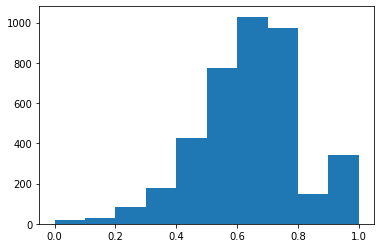

In [ ]:
import matplotlib.pyplot as plt
plt.hist(final_df.similarity)

In [ ]:
final_df.describe()

,similarity
count,4000.000000
mean,0.640697
std,0.170239
min,0.000000
25%,0.542573
50%,0.640934
75%,0.745464
max,1.000000


In [ ]:
up = final_df.loc[final_df.similarity == 1.0]
#final_up = up.iloc[-100:]
#상_index = final_up['index'].values
len(up)

158

In [ ]:
up[:10]

,index,similarity
1,MDRW2100015343.1,1.0
5,MDRW2100015347.1,1.0
54,MDRW2100015396.1,1.0
66,MDRW2100015408.1,1.0
140,MDRW2100015482.1,1.0
177,MDRW2100015519.1,1.0
179,MDRW2100015521.1,1.0
194,MDRW2100015536.1,1.0
239,MDRW2100015581.1,1.0
282,MDRW2100015624.1,1.0


In [ ]:
down = final_df.loc[final_df.similarity <= 0.2]
len(down)

47

In [ ]:
middle = final_df.loc[(final_df.similarity <=0.51) & (final_df.similarity >=0.49)]
len(middle)

111

In [ ]:
data = {
    '상': up.values,
    '중': middle.values,
    '하': down.values
}

In [ ]:
up['range'] = '상'

<ipython-input-20-dc1e682bc7d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up['range'] = '상'


In [ ]:
middle['range'] = '중'
down['range'] = '하'

<ipython-input-22-7d9035fbd628>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle['range'] = '중'
<ipython-input-22-7d9035fbd628>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down['range'] = '하'


In [ ]:
df = pd.concat([up, middle, down])
df.to_excel('range.xlsx')

In [ ]:
pd.read_excel('range.xlsx')

,Unnamed: 0,index,similarity,range
0,1,MDRW2100015343.1,1.000000,상
1,5,MDRW2100015347.1,1.000000,상
2,54,MDRW2100015396.1,1.000000,상
3,66,MDRW2100015408.1,1.000000,상
4,140,MDRW2100015482.1,1.000000,상
...,...,...,...,...
311,3184,MDRW2100018527.1,0.165765,하
312,3393,MDRW2100018736.1,0.047372,하
313,3700,MDRW2100019043.1,0.067905,하
314,3846,MDRW2100019189.1,0.076526,하


In [ ]:
import pickle
import gzip
with gzip.open('index.pickle', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
import gzip
import pickle
with gzip.open('index.pickle','rb') as f:
    data = pickle.load(f)

In [ ]:
data

{'상': array([['MDRW2100015343.1', 1.0],
        ['MDRW2100015347.1', 1.0],
        ['MDRW2100015396.1', 1.0],
        ['MDRW2100015408.1', 1.0],
        ['MDRW2100015482.1', 1.0],
        ['MDRW2100015519.1', 1.0],
        ['MDRW2100015521.1', 1.0],
        ['MDRW2100015536.1', 1.0],
        ['MDRW2100015581.1', 1.0],
        ['MDRW2100015624.1', 1.0],
        ['MDRW2100015667.1', 1.0],
        ['MDRW2100015673.1', 1.0],
        ['MDRW2100015712.1', 1.0],
        ['MDRW2100015737.1', 1.0],
        ['MDRW2100015773.1', 1.0],
        ['MDRW2100015809.1', 1.0],
        ['MDRW2100015870.1', 1.0],
        ['MDRW2100015897.1', 1.0],
        ['MDRW2100015904.1', 1.0],
        ['MDRW2100015925.1', 1.0],
        ['MDRW2100015957.1', 1.0],
        ['MDRW2100015979.1', 1.0],
        ['MDRW2100015983.1', 1.0],
        ['MDRW2100015991.1', 1.0],
        ['MDRW2100015992.1', 1.0],
        ['MDRW2100016018.1', 1.0],
        ['MDRW2100016073.1', 1.0],
        ['MDRW2100016083.1', 1.0],
        ['MDRW2

In [ ]:
import pandas as pd
df = pd.DataFrame(data)
df.to_csv('index.csv')

In [ ]:
import pandas as pd
df = pd.read_csv('final_scores_1.csv')
df2 = pd.read_csv('final_scores_2.csv')
df3 = pd.read_csv('final_scores_3.csv')
df4 = pd.read_csv('final_scores_4.csv')
df5 = pd.read_csv('final_scores_5.csv')
df6 = pd.read_csv('final_scores_6.csv')

In [ ]:
df_f = pd.concat([df, df2, df3, df4, df5, df6])
df_f

,Unnamed: 0,similarity
0,0,0.744935
1,1,1.000000
2,2,0.345916
3,3,0.585908
4,4,0.729984
...,...,...
995,995,0.779360
996,996,0.715548
997,997,0.562705
998,998,0.470482


In [ ]:
df_k = pd.read_csv('df4.csv')

In [ ]:
id = df_k['talk_id'][:6000]

In [ ]:
df_f['id'] = id

In [ ]:
df_f

,Unnamed: 0,similarity,id
0,0,0.744935,MDRW2100015342.1
1,1,1.000000,MDRW2100015343.1
2,2,0.345916,MDRW2100015344.1
3,3,0.585908,MDRW2100015345.1
4,4,0.729984,MDRW2100015346.1
...,...,...,...
995,995,0.779360,MDRW2100016337.1
996,996,0.715548,MDRW2100016338.1
997,997,0.562705,MDRW2100016339.1
998,998,0.470482,MDRW2100016340.1


In [ ]:
df = df_f.iloc[:,[2,1]]

In [ ]:
df.to_csv('final_score.csv', index=False)

## ANOVA 분석

In [ ]:
import pandas as pd
df = pd.read_csv('final_score.csv')
df

,id,similarity
0,MDRW2100015342.1,0.744935
1,MDRW2100015343.1,1.000000
2,MDRW2100015344.1,0.345916
3,MDRW2100015345.1,0.585908
4,MDRW2100015346.1,0.729984
...,...,...
5995,MDRW2100021342.1,0.779360
5996,MDRW2100021343.1,0.715548
5997,MDRW2100021344.1,0.562705
5998,MDRW2100021345.1,0.470482


(array([  23.,   48.,  111.,  261.,  645., 1151., 1535., 1487.,  237.,
         502.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

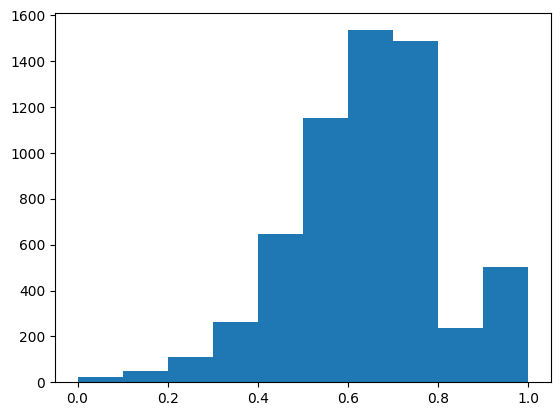

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df.similarity)

In [ ]:
df.id.value_counts()

MDRW2100015342.1    1
MDRW2100019340.1    1
MDRW2100019349.1    1
MDRW2100019348.1    1
MDRW2100019347.1    1
                   ..
MDRW2100017340.1    1
MDRW2100017339.1    1
MDRW2100017338.1    1
MDRW2100017337.1    1
MDRW2100021346.1    1
Name: id, Length: 6000, dtype: int64

In [ ]:
con_up = (df.id=='MDRW2100016142.1') | (df.id=='MDRW2100015726.1') | (df.id=='MDRW2100015992.1') | (df.id=='MDRW2100015443.1') | (df.id=='MDRW2100015722.1')

In [ ]:
con_mid = (df.id=='MDRW2100015526.1') | (df.id=='MDRW2100015708.1') | (df.id=='MDRW2100015429.1') | (df.id=='MDRW2100016223.1') | (df.id=='MDRW2100015744.1')

In [ ]:
con_down = (df.id=='MDRW2100015740.1') | (df.id=='MDRW2100016220.1') | (df.id=='MDRW2100016198.1') | (df.id=='MDRW2100015980.1') | (df.id=='MDRW2100015425.1')

In [ ]:
df.loc[con_up, 'index'] = 'up'
df.loc[con_mid, 'index'] = 'mid'
df.loc[con_down, 'index'] = 'down'

In [ ]:
df_k = df.dropna()
df_k

,id,similarity,index
83,MDRW2100015425.1,0.574727,down
87,MDRW2100015429.1,0.569056,mid
101,MDRW2100015443.1,0.782949,up
184,MDRW2100015526.1,0.606655,mid
366,MDRW2100015708.1,0.689157,mid
380,MDRW2100015722.1,0.794175,up
384,MDRW2100015726.1,0.235938,up
398,MDRW2100015740.1,0.616692,down
402,MDRW2100015744.1,0.647351,mid
638,MDRW2100015980.1,0.460133,down


In [ ]:
up = df_k.loc[df_k['index']=='up', 'similarity']
mid = df_k.loc[df_k['index']=='mid', 'similarity']
down = df_k.loc[df_k['index']=='down', 'similarity']

In [ ]:
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [ ]:
f, p = stats.f_oneway(up, down)

In [ ]:
p

0.5987039494420161

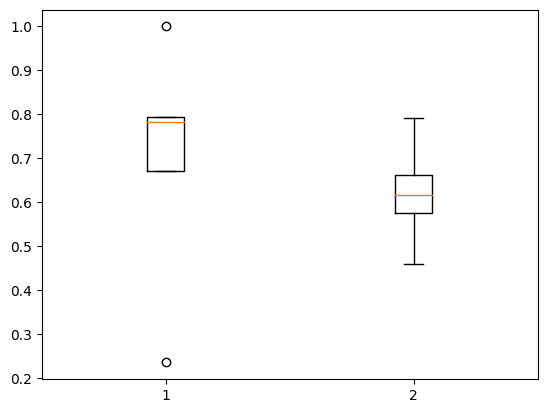

In [ ]:
import matplotlib.pyplot as plt
plot_data = [up, down]
ax = plt.boxplot(plot_data)
plt.show()